# Installing Required Libraries

In [1]:
!pip install openai -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


#Sentiment Analysis Data Preparation and Sampling






In [19]:
import pandas as pd

# Load the data with a fallback encoding option
def load_data(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = [line.strip().rsplit('@', 1) for line in file if line.strip()]
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='ISO-8859-1') as file:
            data = [line.strip().rsplit('@', 1) for line in file if line.strip()]
    return pd.DataFrame(data, columns=['News Headline', 'Sentiment'])

# Example file paths - replace these with your actual file paths
data_all_agree = load_data('Sentences_AllAgree.txt')
data_75_agree = load_data('Sentences_75Agree.txt')

# Combine the datasets
data = pd.concat([data_all_agree, data_75_agree], ignore_index=True)
def select_examples(df, n_per_category=4):
    positive_examples = df[df['Sentiment'] == 'positive']['News Headline'].sample(n=n_per_category, random_state=1).tolist()
    negative_examples = df[df['Sentiment'] == 'negative']['News Headline'].sample(n=n_per_category, random_state=1).tolist()
    neutral_examples = df[df['Sentiment'] == 'neutral']['News Headline'].sample(n=n_per_category, random_state=1).tolist()

    examples = []
    for example in positive_examples:
        examples.append({"text": example, "label": "positive"})
    for example in negative_examples:
        examples.append({"text": example, "label": "negative"})
    for example in neutral_examples:
        examples.append({"text": example, "label": "neutral"})

    return examples

# Dynamically select examples
examples = select_examples(data)

# Ensure the Sentiment column is stripped of extra spaces and standardized
data['Sentiment'] = data['Sentiment'].str.strip().str.lower()

# Adjust 'sample_per_category' depending on whether you want a total of 50 or 60 samples
# Adjust sample size per category for a total of 50 samples
sample_per_category = 17  # 50 samples, equally distributed would be around 17 per category
# Group by 'Sentiment' and sample
sampled_data = data.groupby('Sentiment').apply(lambda x: x.sample(n=sample_per_category, random_state=1)).reset_index(drop=True)

# Display the sampled data
sampled_data[['News Headline', 'Sentiment']]

sample_per_category_train = 150
train_data = data.groupby('Sentiment').apply(lambda x: x.sample(n=sample_per_category_train, random_state=1)).reset_index(drop=True)
train_data.to_csv('fine_tuning_train.csv', index=False)

# Prepare the test dataset by excluding the training data and randomly selecting 500 items
remaining_data = data.drop(train_data.index)
test_data = remaining_data.sample(n=500, random_state=1).reset_index(drop=True)
test_data.to_csv('fine_tuning_test.csv', index=False)
train_data.head(), test_data.head()
# print(examples)
# print(sampled_data)
print(len(train_data), len(test_data) )


450 500


#API Key Management and Initialization for OpenAI in Google Colab


In [3]:
import openai
import pandas as pd
import os
from google.colab import userdata
# Load the API key from an environment variable for security reasons
openai.api_key = os.getenv('OPENAI_API_KEY', userdata.get('OPENAI_API'))



#Sentiment Classification Using OpenAI GPT-3.5 Turbo with Example-Based Prompting


In [4]:

def get_completion(prompt, model="gpt-3.5-turbo", examples=None):
    messages = [
        {"role": "system", "content": "You are a helpful assistant in classifying the sentiment of news."},
    ]
    # Add examples to the prompt if provided
    if examples:
        for example in examples:
            messages.append({"role": "user", "content": example['text']})
            messages.append({"role": "assistant", "content": example['label']})
    messages.append({"role": "user", "content": prompt})

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0
        )
        return response.choices[0].message.content.strip().split('\n')[0].lower()
    except Exception as e:
        return f"error: {str(e)}"

def classify_headline(headline, examples=None):
    prompt = f"Classify the sentiment of this financial headline as positive, negative, or neutral: \"{headline}\" and respond in one word."
    return get_completion(prompt, examples=examples)

# Function to calculate accuracy
def calculate_accuracy(df):
    correct_predictions = df['Correct'].sum()
    accuracy = correct_predictions / len(df)
    return accuracy


#Zero-Shot Sentiment Classification and Accuracy Evaluation


In [ ]:
# Classify each headline and store the prediction using zero-shot prompting
for index, row in sampled_data.iterrows():
    predicted_sentiment = classify_headline(row['News Headline'])
    sampled_data.at[index, 'Predicted Sentiment'] = predicted_sentiment

# Clean the 'Predicted Sentiment' column
sampled_data['Predicted Sentiment'] = sampled_data['Predicted Sentiment'].str.strip().str.lower().str.rstrip('.')

# Recompute the correctness
sampled_data['Correct'] = (sampled_data['Predicted Sentiment'] == sampled_data['Sentiment'])

# Calculate and print the accuracy for the tested subset
accuracy = calculate_accuracy(sampled_data)
print(f"Baseline Accuracy (Zero-Shot): {accuracy * 100:.2f}%")

# Display the detailed results
sampled_data[['News Headline', 'Sentiment', 'Predicted Sentiment', 'Correct']]


Baseline Accuracy (Zero-Shot): 88.24%


,News Headline,Sentiment,Predicted Sentiment,Correct
0,"Operating loss totalled EUR 5.2 mn , compared ...",negative,negative,True
1,Pretax loss totaled EUR 117mn compared to a lo...,negative,negative,True
2,"Profit for the period totalled EUR 0.8 mn , do...",negative,negative,True
3,Commission income fell to EUR 4.6 mn from EUR ...,negative,negative,True
4,Cramo slipped to a pretax loss of EUR 6.7 mill...,negative,negative,True
5,Net sales dropped by 6 % year-on-year to EUR 1...,negative,negative,True
6,"( ADPnews ) - May 4 , 2010 - Finnish cutlery a...",negative,negative,True
7,"Finnish Exel Composites , a technology company...",negative,negative,True
8,Net sales dropped by 6 % year-on-year to EUR 1...,negative,negative,True
9,HELSINKI Thomson Financial - Shares closed lit...,negative,negative,True


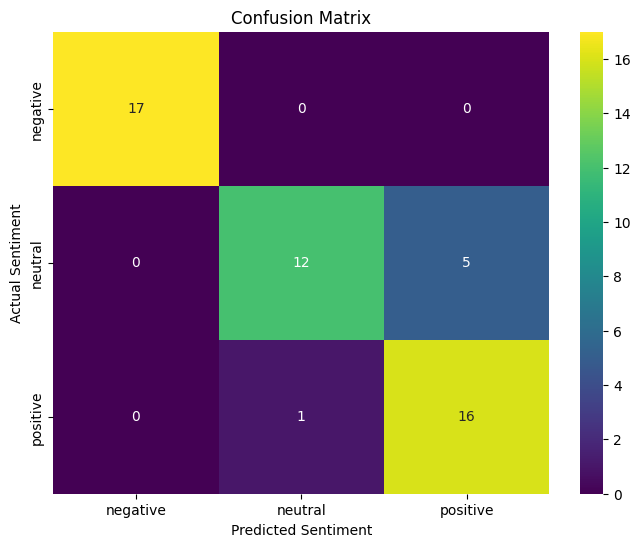

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'Sentiment' and 'Predicted Sentiment'
conf_matrix = confusion_matrix(sampled_data['Sentiment'], sampled_data['Predicted Sentiment'], labels=["negative", "neutral", "positive"])

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=["negative", "neutral", "positive"], columns=["negative", "neutral", "positive"])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()


# 12-Shot Sentiment Classification and Accuracy Evaluation


In [ ]:
# Classify each headline and store the prediction using 12-shot prompting
for index, row in sampled_data.iterrows():
    predicted_sentiment = classify_headline(row['News Headline'], examples=examples)
    sampled_data.at[index, 'Predicted Sentiment'] = predicted_sentiment

# Clean the 'Predicted Sentiment' column
sampled_data['Predicted Sentiment'] = sampled_data['Predicted Sentiment'].str.strip().str.lower().str.rstrip('.')

# Recompute the correctness
sampled_data['Correct'] = (sampled_data['Predicted Sentiment'] == sampled_data['Sentiment'])

# Calculate and print the accuracy for the tested subset
accuracy = calculate_accuracy(sampled_data)
print(f"Baseline Accuracy (12-Shot): {accuracy * 100:.2f}%")

# Display the detailed results
sampled_data[['News Headline', 'Sentiment', 'Predicted Sentiment', 'Correct']]


Baseline Accuracy (12-Shot): 90.20%


,News Headline,Sentiment,Predicted Sentiment,Correct
0,"Operating loss totalled EUR 5.2 mn , compared ...",negative,negative,True
1,Pretax loss totaled EUR 117mn compared to a lo...,negative,negative,True
2,"Profit for the period totalled EUR 0.8 mn , do...",negative,negative,True
3,Commission income fell to EUR 4.6 mn from EUR ...,negative,negative,True
4,Cramo slipped to a pretax loss of EUR 6.7 mill...,negative,negative,True
5,Net sales dropped by 6 % year-on-year to EUR 1...,negative,negative,True
6,"( ADPnews ) - May 4 , 2010 - Finnish cutlery a...",negative,negative,True
7,"Finnish Exel Composites , a technology company...",negative,negative,True
8,Net sales dropped by 6 % year-on-year to EUR 1...,negative,negative,True
9,HELSINKI Thomson Financial - Shares closed lit...,negative,negative,True


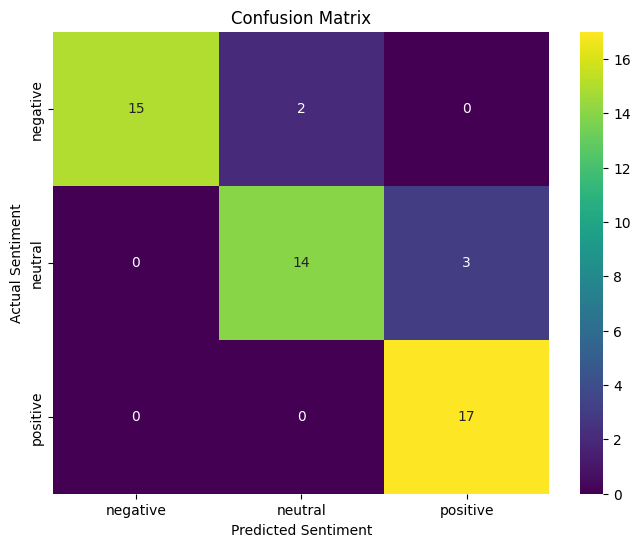

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing 'Sentiment' and 'Predicted Sentiment'
conf_matrix = confusion_matrix(sampled_data['Sentiment'], sampled_data['Predicted Sentiment'], labels=["negative", "neutral", "positive"])

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=["negative", "neutral", "positive"], columns=["negative", "neutral", "positive"])

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()


#Preparing Fine-Tuning Data in JSONL Format for Sentiment Classification


In [12]:
import pandas as pd
import json

# Load the CSV file
file_path = 'fine_tuning_train.csv'
df = pd.read_csv(file_path)

# Ensure the dataset has the expected structure
assert 'News Headline' in df.columns and 'Sentiment' in df.columns, "CSV must contain 'News Headline' and 'Sentiment' columns"

# Sample 150 titles for each sentiment for fine-tuning
sample_per_category = 150
fine_tuning_data = df.groupby('Sentiment').apply(lambda x: x.sample(n=sample_per_category, random_state=42)).reset_index(drop=True)

# Convert the fine-tuning data to JSONL format
jsonl_file_path = 'fine_tuning_data.jsonl'

with open(jsonl_file_path, 'w') as jsonl_file:
    for _, row in fine_tuning_data.iterrows():
        record = {
            "messages": [
                {"role": "system", "content": "You are a helpful assistant to determine the sentiment of a news headline."},
                {"role": "user", "content": str(row['News Headline'])},
                {"role": "assistant", "content": str(row['Sentiment'])}
            ]
        }
        jsonl_file.write(json.dumps(record) + '\n')

print(f"Fine-tuning data has been saved as {jsonl_file_path}")


Fine-tuning data has been saved as fine_tuning_data.jsonl


# Fine-Tuning GPT-3.5 Turbo for Sentiment Classification Using OpenAI API


In [13]:
from openai import OpenAI
os.environ['OPENAI_API_KEY']= userdata.get('OPENAI_API')
client = OpenAI()


# Upload the training file
file_response = client.files.create(
  file=open("fine_tuning_data.jsonl", "rb"),
  purpose="fine-tune"
)

# Store the file ID
file_id = file_response.id
print(f"Training file ID: {file_id}")


Training file ID: file-8IXX9BYC8103i7cpLP74NCmw


In [ ]:
# Start fine-tuning
response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-3.5-turbo",
)

# Get fine-tune job ID
fine_tune_id = response.id
print(f"Fine-tuning job started with ID: {fine_tune_id}")


Fine-tuning job started with ID: ftjob-5GPSPXXAcYrfE8FyIhAZ3PFI


In [ ]:
client.fine_tuning.jobs.list()

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-5GPSPXXAcYrfE8FyIhAZ3PFI', created_at=1720198303, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-FHzPYwhSaT8bzabQjRWClGqz', result_files=[], seed=686449167, status='validating_files', trained_tokens=None, training_file='file-78DhIyiAVA93z2GUtXbfWmXV', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None), FineTuningJob(id='ftjob-WnT3oJW0p9UlItvlEfSEMXHF', created_at=1720143653, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9hT6JY48', finished_at=1720146994, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-FHzPYw

In [ ]:

import time

os.environ['OPENAI_API_KEY']= userdata.get('OPENAI_API')
client = OpenAI()

# Function to check the status of fine-tuning
def check_fine_tune_status(fine_tune_id):
    while True:
        status = client.fine_tuning.jobs.retrieve(fine_tune_id)
        job_status = status.status
        print(f"Status: {job_status}")
        if job_status in ['succeeded', 'failed']:
            break
        time.sleep(60)  # Wait for 1 minute before checking the status again


# Check the fine-tuning job status
check_fine_tune_status(fine_tune_id)


Status: validating_files
Status: validating_files
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: succeeded


In [ ]:
status = client.fine_tuning.jobs.retrieve(fine_tune_id)
fine_tuned_model=(status.fine_tuned_model)

In [16]:
import openai
from openai import OpenAI
# Ensure your API key is set

# List fine-tuned models
fine_tuned_models = client.models.list()
# Print fine-tuned models
for model in fine_tuned_models.data:
    print(model.id)

whisper-1
tts-1
dall-e-2
tts-1-hd-1106
tts-1-hd
gpt-4-turbo-2024-04-09
gpt-4-turbo
gpt-3.5-turbo-1106
dall-e-3
gpt-4-0125-preview
gpt-4-turbo-preview
text-embedding-3-small
text-embedding-3-large
gpt-3.5-turbo-16k
gpt-4-1106-preview
babbage-002
gpt-4o-2024-05-13
gpt-4
gpt-4-0613
gpt-3.5-turbo-0125
tts-1-1106
gpt-3.5-turbo
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
text-embedding-ada-002
davinci-002
gpt-4o
ft:gpt-3.5-turbo-0125:personal::9hT6JLvR:ckpt-step-450
ft:gpt-3.5-turbo-0125:personal::9hT6JCHy:ckpt-step-900
ft:gpt-3.5-turbo-0125:personal::9hT6JY48
ft:gpt-3.5-turbo-0125:personal::9hNnGDNY
ft:gpt-3.5-turbo-0125:personal::9hNnGJxX:ckpt-step-450
ft:gpt-3.5-turbo-0125:personal::9hNnGnRc:ckpt-step-900
ft:gpt-3.5-turbo-0125:personal::9hh6srfp:ckpt-step-450
ft:gpt-3.5-turbo-0125:personal::9hh6ttXh:ckpt-step-900
ft:gpt-3.5-turbo-0125:personal::9hh6tqjC


#Evaluating Fine-Tuned GPT-3.5 Turbo on Test Data for Sentiment Classification


In [27]:
import openai
import pandas as pd
import os
from google.colab import userdata

# Load the API key from an environment variable for security reasons
openai.api_key = os.getenv('OPENAI_API_KEY', userdata.get('OPENAI_API'))

def generate_completion(prompt, model="ft:gpt-3.5-turbo-0125:personal::9hh6tqjC"):
    messages = [
        {"role": "system", "content": "You are an expert sentiment analyzer for financial news."},
        {"role": "user", "content": prompt}
    ]

    try:
        response = openai.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0
        )
        return response.choices[0].message.content.strip().split('\n')[0].lower()
    except Exception as e:
        return f"error: {str(e)}"

def predict_sentiment(headline):
    prompt = f"Classify the sentiment of this financial headline as positive, negative, or neutral: \"{headline}\" and respond in one word."
    return generate_completion(prompt)

# Load the test data
test_file_path = 'fine_tuning_test.csv'
test_data = pd.read_csv(test_file_path)

# Ensure the dataset has the expected structure
assert 'News Headline' in test_data.columns and 'Sentiment' in test_data.columns, "CSV must contain 'News Headline' and 'Sentiment' columns"

# Prepare the test samples
test_samples = [{"prompt": f"News Headline: {row['News Headline']}\nSentiment: "} for _, row in test_data.iterrows()]

# Make predictions on the test data using the predict_sentiment function
predicted_sentiments = [predict_sentiment(sample["prompt"]) for sample in test_samples]

# List of correct sentiments for the test samples
actual_sentiments = test_data['Sentiment'].tolist()

# Compare predicted sentiments with correct sentiments
test_data['Predicted Sentiment'] = predicted_sentiments
test_data['Correct'] = test_data['Predicted Sentiment'] == test_data['Sentiment']

# Calculate accuracy
def compute_accuracy(df):
    correct_predictions = df['Correct'].sum()
    accuracy = correct_predictions / len(df)
    return accuracy

accuracy = compute_accuracy(test_data)

print(f"Base Accuracy: {accuracy * 100:.2f}%")

# Write predictions and results to a CSV file
output_file_path = 'fine_tuning_results.csv'
test_data.to_csv(output_file_path, index=False)
print(f"Results saved to {output_file_path}")


Base Accuracy: 90.80%
Results saved to fine_tuning_results.csv


# Performance Evaluation of Fine-Tuned Model Using Confusion Matrix and Classification Report


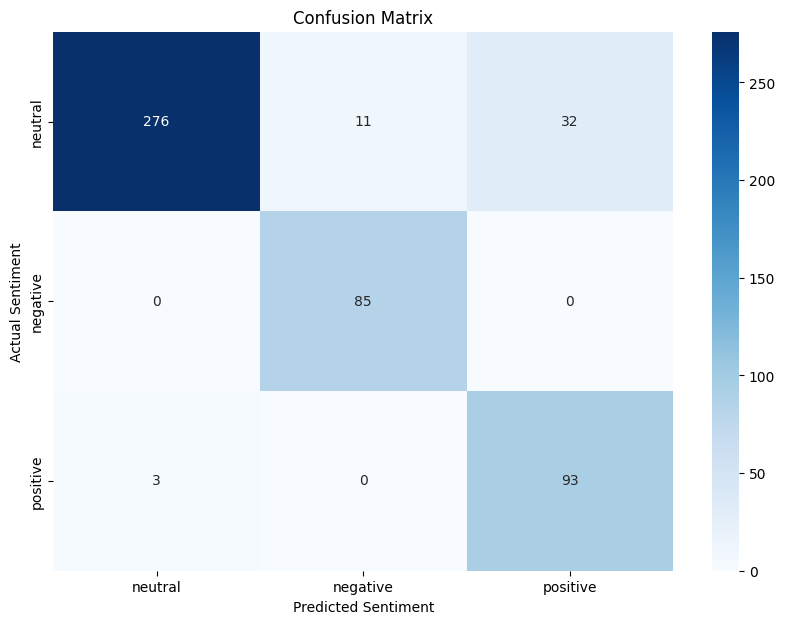


Classification Report:
              precision    recall  f1-score   support

     neutral       0.99      0.87      0.92       319
    negative       0.89      1.00      0.94        85
    positive       0.74      0.97      0.84        96

    accuracy                           0.91       500
   macro avg       0.87      0.94      0.90       500
weighted avg       0.92      0.91      0.91       500



In [28]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file with results
results_file_path = 'fine_tuning_results.csv'  # Ensure this file is in the same directory or provide the correct path
results_df = pd.read_csv(results_file_path)

# Ensure the dataset has the expected structure
assert 'Predicted Sentiment' in results_df.columns and 'Sentiment' in results_df.columns, "CSV must contain 'Predicted Sentiment' and 'Sentiment' columns"

# Define the labels
labels = results_df['Sentiment'].unique()

# Calculate the confusion matrix
conf_matrix = confusion_matrix(results_df['Sentiment'], results_df['Predicted Sentiment'], labels=labels)

# Create a DataFrame for the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('Confusion Matrix')
plt.show()

# Calculate the classification report
class_report = classification_report(results_df['Sentiment'], results_df['Predicted Sentiment'], labels=labels)

# Print the classification report
print("\nClassification Report:")
print(class_report)


#Classifying Sentiments of News Headlines and Evaluating Model Accuracy Against Human Predictions

 **Disclaimer**

 The sentiments of the news headlines have been classified to the best of my knowledge and ability. However, please note that sentiment analysis can be subjective, and the predictions may not always align perfectly with human judgment. Use these results with consideration of potential discrepancies.




In [30]:
headlines_with_sentiments = [
    {"headline": "Think Nvidia looks dear? American shares could get pricier still. How can you tell it is time to get out of the market? In 1929 Joseph Kennedy, an American businessman and politician, supposedly realised the party was over upon hearing a shoeshine boy dispensing stock tips.", "sentiment": "Negative"},
    {"headline": "Microsoft reaches settlement in California over claims it punished employees for taking protected time off. Microsoft is paying $14.4 million to settle a case in California over allegations the company retaliated against employees who had taken legally protected time off.", "sentiment": "Negative"},
    {"headline": "Alphabet’s GOOGL shares have rallied 33.2% in the year-to-date period, outperforming the Zacks Computer & Technology sector’s growth of 28.7%. The company is benefiting from strong momentum in Google Services, mainly driven by Search, YouTube, and Android.", "sentiment": "Positive"},
    {"headline": "Nvidia (NASDAQ: NVDA) recently hit a $3 trillion market cap and is now among the three most valuable companies in the world. Right above it in valuation is Apple (NASDAQ: AAPL), with a market cap of just under $3.4 trillion, while Microsoft is currently in the top spot at just over $3.4 trillion.", "sentiment": "Positive"},
    {"headline": "Adobe: In second-quarter fiscal 2024, the Digital Experience segment generated revenues of $1.33 billion, which improved 9% on a year-over-year basis. For third-quarter fiscal 2024, Adobe expects Digital Experience revenues between $1.325 billion and $1.345 billion.", "sentiment": "Positive"},
    {"headline": "The owner of Saks Fifth Avenue is acquiring Neiman Marcus Group for $2.65 billion — a deal that will unite America’s two largest high-end department-store chains in a bid to grab a bigger share of a slowing industry. Amazon.com Inc. and Salesforce Inc. will help facilitate the deal by Saks owner Hudson’s Bay Co.", "sentiment": "Neutral"},
    {"headline": "Meta is known for its popular family of apps, which includes Facebook, Instagram, WhatsApp, and Messenger. Combined, they have a jaw-dropping 3.24 billion daily active users. This is a massive sum that equals 40% of the global population. However, that figure increased by 7% in Q1 on a year-over-year basis.", "sentiment": "Positive"},
    {"headline": "In June, 19.3 million passengers were transported on Ryanair flights, reflecting an 11% year-over-year increase. RYAAY’s traffic in June was higher than the readings in March, April and May of 13.6 million, 17.3 million, and 18.6 million, respectively. The June load factor (percentage of seats filled by passengers) of 95% remained flat sequentially as well as on a year-over-year basis. The figure was higher than the load factor of 92% reported in April 2024 and 93% reported in March 2024.", "sentiment": "Positive"},
    {"headline": "Goldman and Citi Predict More Gains for Nvidia Supplier Hynix After 90% Rally Shares in South Korea’s SK Hynix Inc., a key supplier to Nvidia Corp., have jumped more than 90% over the past year and Wall Street is predicting further gains. Goldman Sachs Group Inc. upgraded its stock-price target to 290,000 won ($210) on Tuesday, implying a potential gain of 25% from that day’s close. Citigroup Inc. last week raised its prediction to 350,000 won, more than 50% higher than the current share price.", "sentiment": "Positive"},
    {"headline": "AI frenzy expected to have boosted Samsung Q2 profit 13-fold. SEOUL (Reuters) — Samsung Electronics (005930.KS) is expected to post a 13-fold increase in second-quarter profit from a year earlier as demand for artificial intelligence technology fuels a rebound in memory chip prices. Operating profit for the world's biggest maker of memory chips, smartphones and TVs likely rose to 8.8 trillion won ($6.34 billion) in the quarter ended June 30, according to the average of an LSEG SmartEstimate from 27 analysts, weighted toward those who are more consistently accurate.", "sentiment": "Positive"},
    {"headline": "US streaming-service giants are asking a Canadian court to amend Prime Minister Justin Trudeau’s new 5% tax on their revenues in the country to remove the requirement that they fund local news.The Motion Picture Association-Canada — which represents studios including Netflix Inc., Paramount Global and Walt Disney Co. — want the Federal Court of Appeal to quash new obligations forcing foreign streaming platforms to contribute to a local independent news fund as part of the Online Streaming Act.", "sentiment": "Negative"}
]



In [31]:
results = []
correct_predictions = 0

for i, item in enumerate(headlines_with_sentiments):
    headline = item["headline"]
    actual_sentiment = item["sentiment"]
    predicted_sentiment = predict_sentiment(headline)
    results.append({"headline": headline, "actual_sentiment": actual_sentiment, "predicted_sentiment": predicted_sentiment})

    if predicted_sentiment == actual_sentiment.lower():
        correct_predictions += 1

    print(f"Headline {i+1}: {headline}\nActual Sentiment: {actual_sentiment}\nPredicted Sentiment: {predicted_sentiment}\n")


# Optionally, you can save the results to a CSV file for further analysis
results_df = pd.DataFrame(results)
results_df.to_csv('Finance_news_classified.csv', index=False)

Headline 1: Think Nvidia looks dear? American shares could get pricier still. How can you tell it is time to get out of the market? In 1929 Joseph Kennedy, an American businessman and politician, supposedly realised the party was over upon hearing a shoeshine boy dispensing stock tips.
Actual Sentiment: Negative
Predicted Sentiment: negative

Headline 2: Microsoft reaches settlement in California over claims it punished employees for taking protected time off. Microsoft is paying $14.4 million to settle a case in California over allegations the company retaliated against employees who had taken legally protected time off.
Actual Sentiment: Negative
Predicted Sentiment: negative

Headline 3: Alphabet’s GOOGL shares have rallied 33.2% in the year-to-date period, outperforming the Zacks Computer & Technology sector’s growth of 28.7%. The company is benefiting from strong momentum in Google Services, mainly driven by Search, YouTube, and Android.
Actual Sentiment: Positive
Predicted Sentim

In [32]:

accuracy = correct_predictions / len(headlines_with_sentiments) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 90.91%
